# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters. It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PEST++GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin` folder. 

Preferably, executables should be located in a folder that is cited in your computer’s PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

Sometimes this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder:


In [2]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [3]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [4]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [5]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...


    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: D:\Workspace\hugm0001\programs\mf6.2.1\mf6.2.1\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any d

    Solving:  Stress period:     7    Time step:     1
    Solving:  Stress period:     8    Time step:     1
    Solving:  Stress period:     9    Time step:     1
    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    11    Time step:     1
    Solving:  Stress period:    12    Time step:     1
    Solving:  Stress period:    13    Time step:     1
    Solving:  Stress period:    14    Time step:     1
    Solving:  Stress period:    15    Time step:     1
    Solving:  Stress period:    16    Time step:     1
    Solving:  Stress period:    17    Time step:     1
    Solving:  Stress period:    18    Time step:     1
    Solving:  Stress period:    19    Time step:     1
    Solving:  Stress period:    20    Time step:     1
    Solving:  Stress period:    21    Time step:     1


    Solving:  Stress period:    22    Time step:     1
    Solving:  Stress period:    23    Time step:     1
    Solving:  Stress period:    24    Time step:     1
    Solving:  Stress period:    25    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/16 17:23:33
 Elapsed run time:  0.397 Seconds
 
 Normal termination of simulation.


(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [7]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-16 17:23:33.560537 starting: opening PstFrom.log for logging
2022-03-16 17:23:33.561538 starting PstFrom process
2022-03-16 17:23:33.561538 starting: setting up dirs
2022-03-16 17:23:33.561538 starting: removing existing new_d 'freyberg6_template'


2022-03-16 17:23:34.159061 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.597523
2022-03-16 17:23:34.159061 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'


2022-03-16 17:23:38.360299 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:04.201238
2022-03-16 17:23:38.361289 finished: setting up dirs took: 0:00:04.799751


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339320,34.581597,34.611207,34.872171,34.257574,34.136387,34.144465,34.027679,34.310857,34.171589,...,34.878082,34.263187,34.141599,34.150067,33.992380,34.316575,34.177206,33.909874,33.985755,33.890192
32.0,34.422442,34.680583,34.711735,34.972780,34.381277,34.245430,34.272372,34.137936,34.437224,34.313405,...,34.978637,34.386153,34.250207,34.277105,34.087328,34.442105,34.317746,33.992555,34.102614,34.005442
61.0,34.495792,34.777940,34.811524,35.082997,34.481415,34.330031,34.376051,34.218902,34.554365,34.427033,...,35.088895,34.487318,34.335784,34.381822,34.157748,34.559815,34.432489,34.057939,34.195593,34.085966
92.0,34.541159,34.848052,34.884477,35.177157,34.535630,34.371993,34.431372,34.257376,34.631046,34.490293,...,35.183306,34.542680,34.378691,34.438366,34.191361,34.637508,34.497058,34.090606,34.243600,34.120784
122.0,34.537851,34.859231,34.897712,35.213813,34.519752,34.353051,34.414135,34.236501,34.633417,34.475626,...,35.220315,34.527589,34.360284,34.422004,34.173543,34.640812,34.483430,34.076272,34.225665,34.095149


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [10]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [11]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-16 17:23:38.398190 starting: adding observations from output file heads.csv
2022-03-16 17:23:38.398190 starting: adding observations from tabular output file '['heads.csv']'
2022-03-16 17:23:38.398190 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-16 17:23:38.400185 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.001995
2022-03-16 17:23:38.400185 starting: building insfile for tabular output file heads.csv
2022-03-16 17:23:38.407166 finished: building insfile for tabular output file heads.csv took: 0:00:00.006981
2022-03-16 17:23:38.407166 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-16 17:23:38.418179 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.011013
2022-03-16 17:23:38.419206 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.021016


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [12]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [13]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [14]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.10,-477.76,1205.3
32.0,-864.75,-637.87,1635.7
61.0,-1033.10,-764.28,1937.0
92.0,-1117.80,-824.86,2072.0
122.0,-1082.30,-794.46,1982.3


In [15]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-16 17:23:38.451121 starting: adding observations from output file sfr.csv
2022-03-16 17:23:38.451121 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-16 17:23:38.451121 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-16 17:23:38.452118 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.000997
2022-03-16 17:23:38.452118 starting: building insfile for tabular output file sfr.csv
2022-03-16 17:23:38.458102 finished: building insfile for tabular output file sfr.csv took: 0:00:00.005984
2022-03-16 17:23:38.458102 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-16 17:23:38.463090 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.004988
2022-03-16 17:23:38.464097 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.012976


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

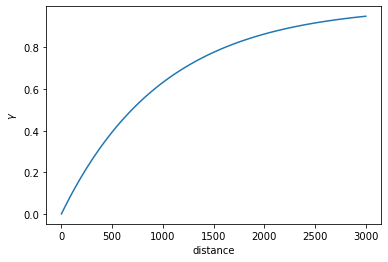

In [16]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [19]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-03-16 17:23:38.790812 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-16 17:23:38.791801 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:38.791801 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-16 17:23:38.792789 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000988
2022-03-16 17:23:38.792789 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-16 17:23:38.794806 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-03-16 17:23:38.794806 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-03-16 17:23:38.804778 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] t

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,dercom,parchglim,offset,scale
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,factor,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,factor,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,factor,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,factor,0.0,1.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,factor,0.0,1.0


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [22]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-03-16 17:23:38.832656 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-16 17:23:38.832656 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.040855
2022-03-16 17:23:38.832656 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-16 17:23:38.833619 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000963
2022-03-16 17:23:38.833619 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-16 17:23:38.834650 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-16 17:23:38.835648 starting: setting up pilot point parameters
2022-03-16 17:23:38.835648 No spatial reference (containing cell spacing) passed.
2022-03-16 17:23:38.835648 OK - using spatial reference in parent object.
2022-03-16 17:23:38.890528 

starting 0
starting 1


starting 2
starting 3


starting 4
starting 5


starting 6
starting 7


starting 8
starting 9


took 3.36176 seconds
2022-03-16 17:23:42.292953 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:03.397439
2022-03-16 17:23:42.293206 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2022-03-16 17:23:42.293206 saving zone array freyberg6_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl
2022-03-16 17:23:42.297197 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:03.464541


Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [23]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-03-16 17:23:42.303961 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-16 17:23:42.304926 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:42.304926 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-16 17:23:42.305925 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000999
2022-03-16 17:23:42.305925 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-16 17:23:42.306922 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-03-16 17:23:42.307918 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-03-16 17:23:42.313902 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_laye

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [24]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [25]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-03-16 17:23:42.330226 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-16 17:23:42.330226 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.025300
2022-03-16 17:23:42.331192 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-16 17:23:42.332195 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.001003
2022-03-16 17:23:42.332195 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-16 17:23:42.333223 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-03-16 17:23:42.333223 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-03-16 17:23:42.343194 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k

2022-03-16 17:23:42.432156 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-16 17:23:42.434158 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-16 17:23:42.434158 starting: writing template file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl for ['npf_k_layer3_gr_inst:0']
2022-03-16 17:23:42.445131 finished: writing template file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl for ['npf_k_layer3_gr_inst:0'] took: 0:00:00.010973
2022-03-16 17:23:42.445131 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-16 17:23:42.445131 saving zone array freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl
2022-03-16 17:23:42.451116 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.019945
2022-03-16 17:23:42.451116 starti

2022-03-16 17:23:42.506002 32 pilot point parameters created
2022-03-16 17:23:42.506002 pilot point 'pargp':npf_k_layer3_pp
2022-03-16 17:23:42.506998 finished: setting up pilot point parameters took: 0:00:00.052882


2022-03-16 17:23:42.511985 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl'
2022-03-16 17:23:42.511985 saving zone array freyberg6_template\npf_k_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl
2022-03-16 17:23:42.515974 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.064858
2022-03-16 17:23:42.515974 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-16 17:23:42.515974 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:42.516943 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-16 17:23:42.516943 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00
2022-03-16 17:23:42.517970 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape

Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [26]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-03-16 17:23:42.535922 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-16 17:23:42.535922 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.019948
2022-03-16 17:23:42.535922 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-16 17:23:42.536921 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.000999
2022-03-16 17:23:42.537918 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-16 17:23:42.538915 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-16 17:23:42.538915 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-03-16 17:23:42.548978 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv

2022-03-16 17:23:42.619759 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-16 17:23:42.620781 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.001022
2022-03-16 17:23:42.620781 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-16 17:23:42.622781 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_cn_inst0_constant.csv.tpl'
2022-03-16 17:23:42.622781 starting: writing template file freyberg6_template\npf_k33_layer1_cn_inst0_constant.csv.tpl for ['npf_k33_layer1_cn_inst:0']
2022-03-16 17:23:42.627770 finished: writing template file freyberg6_template\npf_k33_layer1_cn_inst0_constant.csv.tpl for ['npf_k33_layer1_cn_inst:0'] took: 0:00:00.004989
2022-03-16 17:23:42.628764 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_cn_inst0_constant.csv.tpl'
2022-03-16 17:23:42.628764 saving zone array freyberg6_template\npf_k33_layer1_cn_inst0_

2022-03-16 17:23:42.709752 32 pilot point parameters created
2022-03-16 17:23:42.709752 pilot point 'pargp':npf_k33_layer2_pp
2022-03-16 17:23:42.709752 finished: setting up pilot point parameters took: 0:00:00.053064
2022-03-16 17:23:42.714744 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl'
2022-03-16 17:23:42.714744 saving zone array freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl


2022-03-16 17:23:42.718728 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.065032
2022-03-16 17:23:42.719729 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-16 17:23:42.719729 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:42.719729 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-16 17:23:42.720722 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.000993
2022-03-16 17:23:42.720722 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-16 17:23:42.721720 starting: writing array-style template file 'freyberg6_template\npf_k33_layer2_cn_inst0_constant.csv.tpl'
2022-03-16 17:23:42.722727 starting: writing template file freyberg6_template\npf_k33_layer2_cn_inst0_constant.csv.tpl for ['

2022-03-16 17:23:42.806772 finished: setting up pilot point parameters took: 0:00:00.054033
2022-03-16 17:23:42.811727 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl'
2022-03-16 17:23:42.811727 saving zone array freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl
2022-03-16 17:23:42.815743 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt'] took: 0:00:00.064998
2022-03-16 17:23:42.816762 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt']
2022-03-16 17:23:42.816762 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.066017
2022-03-16 17:23:42.816762 starting: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt
2022-03-16 17:23:42.817740 finished: loading array freyberg6_template\freybe

2022-03-16 17:23:42.903796 pilot point 'pargp':sto_ss_layer2_pp
2022-03-16 17:23:42.904806 finished: setting up pilot point parameters took: 0:00:00.053869
2022-03-16 17:23:42.909780 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl'
2022-03-16 17:23:42.909780 saving zone array freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2022-03-16 17:23:42.913802 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.065827
2022-03-16 17:23:42.914767 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-16 17:23:42.914767 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:42.914767 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-16 17:23:42.915793 finished: lo

2022-03-16 17:23:43.001474 finished: setting up pilot point parameters took: 0:00:00.050892
2022-03-16 17:23:43.007430 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.007430 saving zone array freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.011459 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.064836
2022-03-16 17:23:43.011459 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']
2022-03-16 17:23:43.012476 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064850
2022-03-16 17:23:43.012476 starting: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt
2022-03-16 17:23:43.013414 finished: loading array freyberg6_template\freyberg6.st

2022-03-16 17:23:43.098332 finished: setting up pilot point parameters took: 0:00:00.051009
2022-03-16 17:23:43.104319 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.104319 saving zone array freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.108272 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.063912
2022-03-16 17:23:43.108272 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-16 17:23:43.108272 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:43.108272 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-16 17:23:43.109269 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took:

#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [27]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [28]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-03-16 17:23:43.137208 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-16 17:23:43.137208 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.028936
2022-03-16 17:23:43.137208 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-16 17:23:43.139205 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.001997
2022-03-16 17:23:43.139205 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-16 17:23:43.140187 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-16 17:23:43.140187 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']
2022-03-16 17:23:43.150189 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv

2022-03-16 17:23:43.211133 32 pilot point parameters created
2022-03-16 17:23:43.211133 pilot point 'pargp':rch_recharge_1_pp
2022-03-16 17:23:43.211133 finished: setting up pilot point parameters took: 0:00:00.051964
2022-03-16 17:23:43.216119 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.216119 saving zone array freyberg6_template\rch_recharge_1_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.220112 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.063968
2022-03-16 17:23:43.220112 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-16 17:23:43.221077 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064933
2022-03-16 17:23:43.221077 starting: loading arra

2022-03-16 17:23:43.320995 32 pilot point parameters created
2022-03-16 17:23:43.322007 pilot point 'pargp':rch_recharge_10_pp


2022-03-16 17:23:43.322007 finished: setting up pilot point parameters took: 0:00:00.052870
2022-03-16 17:23:43.326979 starting: writing array-based template file 'freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.328012 saving zone array freyberg6_template\rch_recharge_10_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.331006 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.063866
2022-03-16 17:23:43.332003 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-16 17:23:43.332003 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:43.332003 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-16 17:23:43.333000 finished: loading array freyberg6_template\freyberg6.rch_recharg

2022-03-16 17:23:43.431817 32 pilot point parameters created
2022-03-16 17:23:43.431817 pilot point 'pargp':rch_recharge_11_pp
2022-03-16 17:23:43.431817 finished: setting up pilot point parameters took: 0:00:00.050905
2022-03-16 17:23:43.436804 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.437118 saving zone array freyberg6_template\rch_recharge_11_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.440112 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.062158
2022-03-16 17:23:43.440112 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-16 17:23:43.441109 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.063155
2022-03-16 17:23:43.441109 starting: loadin

2022-03-16 17:23:43.542174 32 pilot point parameters created
2022-03-16 17:23:43.542174 pilot point 'pargp':rch_recharge_12_pp
2022-03-16 17:23:43.542174 finished: setting up pilot point parameters took: 0:00:00.053129
2022-03-16 17:23:43.546871 starting: writing array-based template file 'freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.546871 saving zone array freyberg6_template\rch_recharge_12_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.550894 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.063831
2022-03-16 17:23:43.550894 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-16 17:23:43.550894 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:43.550894 starting: loading array freyberg6_tem

2022-03-16 17:23:43.653614 32 pilot point parameters created
2022-03-16 17:23:43.653614 pilot point 'pargp':rch_recharge_13_pp
2022-03-16 17:23:43.653614 finished: setting up pilot point parameters took: 0:00:00.052887
2022-03-16 17:23:43.658572 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.658572 saving zone array freyberg6_template\rch_recharge_13_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.662561 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt'] took: 0:00:00.064826
2022-03-16 17:23:43.662561 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt']
2022-03-16 17:23:43.662561 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064826
2022-03-16 17:23:43.663558 starting: loadin

2022-03-16 17:23:43.766457 32 pilot point parameters created
2022-03-16 17:23:43.766457 pilot point 'pargp':rch_recharge_14_pp
2022-03-16 17:23:43.766457 finished: setting up pilot point parameters took: 0:00:00.054030
2022-03-16 17:23:43.772423 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.772423 saving zone array freyberg6_template\rch_recharge_14_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.776428 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.066993
2022-03-16 17:23:43.776428 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']
2022-03-16 17:23:43.776428 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:43.776428 starting: loading array freyberg6_tem

2022-03-16 17:23:43.877162 32 pilot point parameters created
2022-03-16 17:23:43.877162 pilot point 'pargp':rch_recharge_15_pp
2022-03-16 17:23:43.878188 finished: setting up pilot point parameters took: 0:00:00.051851
2022-03-16 17:23:43.882176 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.882176 saving zone array freyberg6_template\rch_recharge_15_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.886138 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.062835
2022-03-16 17:23:43.886138 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-16 17:23:43.886138 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.062835
2022-03-16 17:23:43.886138 starting: loadin

2022-03-16 17:23:43.989860 32 pilot point parameters created
2022-03-16 17:23:43.990857 pilot point 'pargp':rch_recharge_16_pp
2022-03-16 17:23:43.990857 finished: setting up pilot point parameters took: 0:00:00.053855
2022-03-16 17:23:43.995844 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl'
2022-03-16 17:23:43.995844 saving zone array freyberg6_template\rch_recharge_16_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl
2022-03-16 17:23:43.999833 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.065824
2022-03-16 17:23:43.999833 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-16 17:23:43.999833 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:43.999833 starting: loading array freyberg6_tem

2022-03-16 17:23:44.100719 32 pilot point parameters created
2022-03-16 17:23:44.100719 pilot point 'pargp':rch_recharge_17_pp
2022-03-16 17:23:44.101715 finished: setting up pilot point parameters took: 0:00:00.050990
2022-03-16 17:23:44.105704 starting: writing array-based template file 'freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.105704 saving zone array freyberg6_template\rch_recharge_17_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.109694 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt'] took: 0:00:00.061989
2022-03-16 17:23:44.110586 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt']
2022-03-16 17:23:44.110586 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.062881
2022-03-16 17:23:44.110586 starting: loadin

2022-03-16 17:23:44.209449 32 pilot point parameters created
2022-03-16 17:23:44.210447 pilot point 'pargp':rch_recharge_18_pp
2022-03-16 17:23:44.210447 finished: setting up pilot point parameters took: 0:00:00.051861
2022-03-16 17:23:44.215405 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.215405 saving zone array freyberg6_template\rch_recharge_18_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.219394 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.063827
2022-03-16 17:23:44.219394 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-16 17:23:44.219394 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:44.219394 starting: loading array freyberg6_tem

2022-03-16 17:23:44.321027 32 pilot point parameters created
2022-03-16 17:23:44.321027 pilot point 'pargp':rch_recharge_19_pp
2022-03-16 17:23:44.321992 finished: setting up pilot point parameters took: 0:00:00.053729
2022-03-16 17:23:44.326979 starting: writing array-based template file 'freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.326979 saving zone array freyberg6_template\rch_recharge_19_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.330968 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.065650
2022-03-16 17:23:44.331271 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-16 17:23:44.331271 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064965
2022-03-16 17:23:44.331271 starting: loadin

2022-03-16 17:23:44.432037 32 pilot point parameters created
2022-03-16 17:23:44.432037 pilot point 'pargp':rch_recharge_2_pp
2022-03-16 17:23:44.432037 finished: setting up pilot point parameters took: 0:00:00.050898
2022-03-16 17:23:44.437051 starting: writing array-based template file 'freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.437051 saving zone array freyberg6_template\rch_recharge_2_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.441042 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt'] took: 0:00:00.062888
2022-03-16 17:23:44.441042 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-16 17:23:44.442011 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:44.442011 starting: loading array freyberg6_template\

2022-03-16 17:23:44.542302 32 pilot point parameters created
2022-03-16 17:23:44.542302 pilot point 'pargp':rch_recharge_20_pp
2022-03-16 17:23:44.543338 finished: setting up pilot point parameters took: 0:00:00.052386
2022-03-16 17:23:44.547318 starting: writing array-based template file 'freyberg6_template\rch_recharge_20_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.547318 saving zone array freyberg6_template\rch_recharge_20_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_20_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.551310 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt'] took: 0:00:00.063312
2022-03-16 17:23:44.551310 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt']
2022-03-16 17:23:44.552296 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064298
2022-03-16 17:23:44.552296 starting: loadin

2022-03-16 17:23:44.653844 32 pilot point parameters created
2022-03-16 17:23:44.654842 pilot point 'pargp':rch_recharge_21_pp
2022-03-16 17:23:44.654842 finished: setting up pilot point parameters took: 0:00:00.053689
2022-03-16 17:23:44.659828 starting: writing array-based template file 'freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.659828 saving zone array freyberg6_template\rch_recharge_21_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.663854 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.064695
2022-03-16 17:23:44.663854 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt']
2022-03-16 17:23:44.663854 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:44.664815 starting: loading array freyberg6_tem

2022-03-16 17:23:44.765645 32 pilot point parameters created
2022-03-16 17:23:44.765645 pilot point 'pargp':rch_recharge_22_pp
2022-03-16 17:23:44.765645 finished: setting up pilot point parameters took: 0:00:00.050933
2022-03-16 17:23:44.770632 starting: writing array-based template file 'freyberg6_template\rch_recharge_22_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.770632 saving zone array freyberg6_template\rch_recharge_22_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_22_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.774620 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt'] took: 0:00:00.062892
2022-03-16 17:23:44.774620 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt']
2022-03-16 17:23:44.774620 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.062892
2022-03-16 17:23:44.774620 starting: loadin

2022-03-16 17:23:44.875392 32 pilot point parameters created
2022-03-16 17:23:44.876390 pilot point 'pargp':rch_recharge_23_pp
2022-03-16 17:23:44.876390 finished: setting up pilot point parameters took: 0:00:00.051833
2022-03-16 17:23:44.880418 starting: writing array-based template file 'freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.881408 saving zone array freyberg6_template\rch_recharge_23_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.884398 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt'] took: 0:00:00.062832
2022-03-16 17:23:44.885405 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-16 17:23:44.885405 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:44.885405 starting: loading array freyberg6_tem

2022-03-16 17:23:44.988186 32 pilot point parameters created
2022-03-16 17:23:44.988186 pilot point 'pargp':rch_recharge_24_pp
2022-03-16 17:23:44.988186 finished: setting up pilot point parameters took: 0:00:00.051896
2022-03-16 17:23:44.993170 starting: writing array-based template file 'freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl'
2022-03-16 17:23:44.993170 saving zone array freyberg6_template\rch_recharge_24_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl
2022-03-16 17:23:44.998155 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt'] took: 0:00:00.064888
2022-03-16 17:23:44.998155 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt']
2022-03-16 17:23:44.998155 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064888
2022-03-16 17:23:44.998155 starting: loadin

2022-03-16 17:23:45.099303 32 pilot point parameters created
2022-03-16 17:23:45.099303 pilot point 'pargp':rch_recharge_25_pp
2022-03-16 17:23:45.099303 finished: setting up pilot point parameters took: 0:00:00.049317
2022-03-16 17:23:45.104320 starting: writing array-based template file 'freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.104320 saving zone array freyberg6_template\rch_recharge_25_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.108315 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt'] took: 0:00:00.061286
2022-03-16 17:23:45.108315 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt']
2022-03-16 17:23:45.109277 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:45.109277 starting: loading array freyberg6_tem

2022-03-16 17:23:45.210007 32 pilot point parameters created
2022-03-16 17:23:45.210007 pilot point 'pargp':rch_recharge_3_pp
2022-03-16 17:23:45.210007 finished: setting up pilot point parameters took: 0:00:00.050834
2022-03-16 17:23:45.215023 starting: writing array-based template file 'freyberg6_template\rch_recharge_3_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.216039 saving zone array freyberg6_template\rch_recharge_3_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_3_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.219012 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt'] took: 0:00:00.062829
2022-03-16 17:23:45.220020 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt']
2022-03-16 17:23:45.220020 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.063837
2022-03-16 17:23:45.220020 starting: loading arra

2022-03-16 17:23:45.323100 32 pilot point parameters created
2022-03-16 17:23:45.323100 pilot point 'pargp':rch_recharge_4_pp
2022-03-16 17:23:45.323100 finished: setting up pilot point parameters took: 0:00:00.052901
2022-03-16 17:23:45.328077 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.328077 saving zone array freyberg6_template\rch_recharge_4_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.332066 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.064185
2022-03-16 17:23:45.332066 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-16 17:23:45.332066 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:45.332066 starting: loading array freyberg6_template\

2022-03-16 17:23:45.435016 32 pilot point parameters created
2022-03-16 17:23:45.435016 pilot point 'pargp':rch_recharge_5_pp
2022-03-16 17:23:45.435016 finished: setting up pilot point parameters took: 0:00:00.052852
2022-03-16 17:23:45.440002 starting: writing array-based template file 'freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.440002 saving zone array freyberg6_template\rch_recharge_5_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.443989 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt'] took: 0:00:00.064826
2022-03-16 17:23:45.443989 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt']
2022-03-16 17:23:45.444958 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.065795
2022-03-16 17:23:45.444958 starting: loading arra

2022-03-16 17:23:45.546184 32 pilot point parameters created
2022-03-16 17:23:45.547182 pilot point 'pargp':rch_recharge_6_pp
2022-03-16 17:23:45.547182 finished: setting up pilot point parameters took: 0:00:00.053840
2022-03-16 17:23:45.552198 starting: writing array-based template file 'freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.552198 saving zone array freyberg6_template\rch_recharge_6_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.555188 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt'] took: 0:00:00.063841
2022-03-16 17:23:45.556188 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt']
2022-03-16 17:23:45.556188 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:45.556188 starting: loading array freyberg6_template\

2022-03-16 17:23:45.657054 32 pilot point parameters created
2022-03-16 17:23:45.658053 pilot point 'pargp':rch_recharge_7_pp
2022-03-16 17:23:45.658053 finished: setting up pilot point parameters took: 0:00:00.052998
2022-03-16 17:23:45.662043 starting: writing array-based template file 'freyberg6_template\rch_recharge_7_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.663037 saving zone array freyberg6_template\rch_recharge_7_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_7_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.666041 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt'] took: 0:00:00.063957
2022-03-16 17:23:45.667064 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt']
2022-03-16 17:23:45.667064 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064980
2022-03-16 17:23:45.667064 starting: loading arra

2022-03-16 17:23:45.767937 32 pilot point parameters created
2022-03-16 17:23:45.767937 pilot point 'pargp':rch_recharge_8_pp
2022-03-16 17:23:45.767937 finished: setting up pilot point parameters took: 0:00:00.052003
2022-03-16 17:23:45.772953 starting: writing array-based template file 'freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.772953 saving zone array freyberg6_template\rch_recharge_8_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.776942 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt'] took: 0:00:00.063002
2022-03-16 17:23:45.776942 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-16 17:23:45.776942 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:45.777911 starting: loading array freyberg6_template\

2022-03-16 17:23:45.879656 32 pilot point parameters created
2022-03-16 17:23:45.879656 pilot point 'pargp':rch_recharge_9_pp
2022-03-16 17:23:45.879656 finished: setting up pilot point parameters took: 0:00:00.052828
2022-03-16 17:23:45.884672 starting: writing array-based template file 'freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl'
2022-03-16 17:23:45.884672 saving zone array freyberg6_template\rch_recharge_9_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl
2022-03-16 17:23:45.888662 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt'] took: 0:00:00.064827
2022-03-16 17:23:45.888662 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt']
2022-03-16 17:23:45.888662 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.064827
2022-03-16 17:23:45.888662 starting: loading arra

### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

2022-03-16 17:23:45.934797 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-16 17:23:45.934797 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:45.934797 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-16 17:23:45.935844 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-16 17:23:45.936826 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.000982
2022-03-16 17:23:45.936826 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-16 17:23:45.937788 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.002991
2022-03-16 17:23:45.937788 starting: writing list-style template file 'freyberg6_templa

2022-03-16 17:23:45.957674 finished: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt'] took: 0:00:00.022877
2022-03-16 17:23:45.957674 starting: adding constant type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-16 17:23:45.957674 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.022877
2022-03-16 17:23:45.957674 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-16 17:23:45.957674 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-16 17:23:45.958641 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.000967
2022-03-16 17:23:45.958641 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-16 17:23:45.959639 finished: loading lis

Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [31]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-03-16 17:23:46.020476 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-16 17:23:46.020476 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.117850
2022-03-16 17:23:46.020476 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-16 17:23:46.020476 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-16 17:23:46.022470 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001994
2022-03-16 17:23:46.022470 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-16 17:23:46.023467 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.002991
2022-03-16 17:23:46.023467 starting: writing list-style template 

2022-03-16 17:23:46.058196 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2022-03-16 17:23:46.058196 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:46.058196 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-16 17:23:46.058196 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-16 17:23:46.059165 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.000969
2022-03-16 17:23:46.060151 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_10.txt' of shape (6, 4)
2022-03-16 17:23:46.060151 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.001955
2022-03-16 17:23:46.061282 starting: writing list-style template file 'freyberg6

2022-03-16 17:23:46.112298 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.017992
2022-03-16 17:23:46.112298 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt']
2022-03-16 17:23:46.112298 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_11.txt
2022-03-16 17:23:46.112298 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt
2022-03-16 17:23:46.113326 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.001028
2022-03-16 17:23:46.113326 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_11.txt' of shape (6, 4)
2022-03-16 17:23:46.114293 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.001995
2022-03-16 17:23:46.114293 starting: writing list-style template file 'freyberg6_

2022-03-16 17:23:46.130349 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.018051
2022-03-16 17:23:46.130349 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-16 17:23:46.130349 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:46.131316 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-16 17:23:46.131316 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-16 17:23:46.132345 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.001029
2022-03-16 17:23:46.132345 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-16 17:23:46.133340 finished: loading list-style freyberg6_

2022-03-16 17:23:46.148306 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt'] took: 0:00:00.017957
2022-03-16 17:23:46.149270 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-16 17:23:46.149270 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-16 17:23:46.149270 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-16 17:23:46.150296 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.001026
2022-03-16 17:23:46.150296 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-16 17:23:46.151289 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.002019
2022-03-16 17:23:46.151289 starting: writing list-style template file 'freyberg6_

2022-03-16 17:23:46.204756 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt']
2022-03-16 17:23:46.204756 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:46.204756 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-16 17:23:46.204756 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-16 17:23:46.205741 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.000985
2022-03-16 17:23:46.206749 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_14.txt' of shape (6, 4)
2022-03-16 17:23:46.206749 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.001993
2022-03-16 17:23:46.207767 starting: writing list-style template file 'freyberg6

2022-03-16 17:23:46.253289 finished: writing list-style template file 'freyberg6_template\wel_cst_inst6_constant.csv.tpl' took: 0:00:00.010007
2022-03-16 17:23:46.260270 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt'] took: 0:00:00.018581
2022-03-16 17:23:46.260270 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt']
2022-03-16 17:23:46.260270 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-16 17:23:46.260270 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-16 17:23:46.261297 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt took: 0:00:00.001027
2022-03-16 17:23:46.261297 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_15.txt' of shape (6, 4)
2022-03-16 17:23:46.262294 finished: loading list-style freyberg6_template

2022-03-16 17:23:46.297547 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt'] took: 0:00:00.018981
2022-03-16 17:23:46.297547 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt']
2022-03-16 17:23:46.298515 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-16 17:23:46.298515 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-16 17:23:46.299541 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.001026
2022-03-16 17:23:46.299541 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_16.txt' of shape (6, 4)
2022-03-16 17:23:46.300538 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.002023
2022-03-16 17:23:46.300538 starting: writing list-style template file 'freyberg6_

2022-03-16 17:23:46.316498 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt'] took: 0:00:00.018951
2022-03-16 17:23:46.317464 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-16 17:23:46.317464 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.038898
2022-03-16 17:23:46.317464 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-16 17:23:46.317464 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-16 17:23:46.318490 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001026
2022-03-16 17:23:46.318490 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-16 17:23:46.319459 finished: loading 

2022-03-16 17:23:46.336413 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-16 17:23:46.336413 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-16 17:23:46.336413 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-16 17:23:46.337435 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001022
2022-03-16 17:23:46.338436 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-16 17:23:46.339434 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.003021
2022-03-16 17:23:46.339434 starting: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl'
2022-03-16 17:23:46.349408 finished: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl'

2022-03-16 17:23:46.396104 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt'] took: 0:00:00.019947
2022-03-16 17:23:46.396104 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt']
2022-03-16 17:23:46.396104 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.038722
2022-03-16 17:23:46.397133 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-16 17:23:46.397133 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-16 17:23:46.398130 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.000997
2022-03-16 17:23:46.398130 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_19.txt' of shape (6, 4)
2022-03-16 17:23:46.399127 finished: loading 

2022-03-16 17:23:46.434164 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-16 17:23:46.434164 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:46.435175 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-16 17:23:46.435175 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-16 17:23:46.436171 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.000996
2022-03-16 17:23:46.436171 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-16 17:23:46.437128 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.001953
2022-03-16 17:23:46.437128 starting: writing list-style template file 'freyberg6_templ

2022-03-16 17:23:46.490015 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt'] took: 0:00:00.018949
2022-03-16 17:23:46.490015 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt']
2022-03-16 17:23:46.490015 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-16 17:23:46.491013 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-16 17:23:46.492018 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.001005
2022-03-16 17:23:46.492018 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2022-03-16 17:23:46.493009 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.002994
2022-03-16 17:23:46.493009 starting: writing list-style template file 'freyberg6_

2022-03-16 17:23:46.814032 finished: writing list-style template file 'freyberg6_template\wel_grd_inst12_grid.csv.tpl' took: 0:00:00.321023
2022-03-16 17:23:46.820030 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt'] took: 0:00:00.330015
2022-03-16 17:23:46.820030 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt']
2022-03-16 17:23:46.820030 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:46.820030 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-16 17:23:46.821013 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-16 17:23:46.822044 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.001031
2022-03-16 17:23:46.822044 loaded list-style 'fr

2022-03-16 17:23:47.008242 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt'] took: 0:00:00.066027
2022-03-16 17:23:47.009237 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt']
2022-03-16 17:23:47.009237 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.085004
2022-03-16 17:23:47.009237 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-16 17:23:47.009237 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-16 17:23:47.010206 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.000969
2022-03-16 17:23:47.010206 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_24.txt' of shape (6, 4)
2022-03-16 17:23:47.011233 finished: loading 

2022-03-16 17:23:47.207245 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-16 17:23:47.207245 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:47.207245 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-16 17:23:47.207245 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-16 17:23:47.208240 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.000995
2022-03-16 17:23:47.209262 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-16 17:23:47.209262 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.002017
2022-03-16 17:23:47.210251 starting: writing list-style template file 'freyberg6_templ

2022-03-16 17:23:47.394074 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt'] took: 0:00:00.023905
2022-03-16 17:23:47.394074 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt']
2022-03-16 17:23:47.394074 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:47.395072 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-16 17:23:47.395072 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-16 17:23:47.396069 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt took: 0:00:00.000997
2022-03-16 17:23:47.396069 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_8.txt' of shape (6, 4)
2022-03-16 17:23:47.397066 finished: loading list-style freyberg6_templa

And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [32]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-03-16 17:23:47.479465 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-16 17:23:47.479465 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:47.479465 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-16 17:23:47.480461 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-16 17:23:47.481459 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.000998
2022-03-16 17:23:47.481459 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-16 17:23:47.482457 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.002992
2022-03-16 17:23:47.483453 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0

,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,dercom,parchglim,offset,scale
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,1,factor,0.0,1.0


In [33]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-03-16 17:23:47.531453 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-03-16 17:23:47.531453 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:47.531453 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-16 17:23:47.531453 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-16 17:23:47.532450 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.000997
2022-03-16 17:23:47.532450 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-03-16 17:23:47.533447 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.001994
2022-03-16 17:23:47.533447 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-03-16 17:23:47.5

2022-03-16 17:23:47.574378 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_11.txt']
2022-03-16 17:23:47.575373 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:47.575373 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-16 17:23:47.575373 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-16 17:23:47.577369 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.001996
2022-03-16 17:23:47.577369 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_11.txt' of shape (1, 3)
2022-03-16 17:23:47.578371 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.002998
2022-03-16 17:23:47.578371 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst2_grid.csv.tpl'
2022-03-16 17:2

2022-03-16 17:23:47.675108 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl' took: 0:00:00.011996
2022-03-16 17:23:47.681092 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt'] took: 0:00:00.019975
2022-03-16 17:23:47.682061 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_16.txt']
2022-03-16 17:23:47.682061 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.020944
2022-03-16 17:23:47.682061 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-16 17:23:47.682061 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-16 17:23:47.683087 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.001026
2022-03-16 17:23:47.683087 loaded list-style 'freyberg6_template\freyberg

2022-03-16 17:23:47.724966 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt']
2022-03-16 17:23:47.724966 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.021933
2022-03-16 17:23:47.724966 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-16 17:23:47.724966 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-16 17:23:47.725972 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.001006
2022-03-16 17:23:47.725972 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_18.txt' of shape (1, 3)
2022-03-16 17:23:47.726940 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.001974
2022-03-16 17:23:47.726940 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst9_grid.csv

2022-03-16 17:23:47.766935 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_19.txt'] took: 0:00:00.021036
2022-03-16 17:23:47.767925 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_2.txt']
2022-03-16 17:23:47.767925 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.022026
2022-03-16 17:23:47.767925 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_2.txt
2022-03-16 17:23:47.767925 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_2.txt
2022-03-16 17:23:47.769913 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_2.txt took: 0:00:00.001988
2022-03-16 17:23:47.769913 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_2.txt' of shape (1, 3)
2022-03-16 17:23:47.769913 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_2.

2022-03-16 17:23:47.861631 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt'] took: 0:00:00.022938
2022-03-16 17:23:47.862628 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt']
2022-03-16 17:23:47.862628 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.023935
2022-03-16 17:23:47.862628 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-16 17:23:47.862628 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-16 17:23:47.863627 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.000999
2022-03-16 17:23:47.864623 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_23.txt' of shape (1, 3)
2022-03-16 17:23:47.865621 finished: loading list-style freyberg6_template\freyberg6.sfr_periodda

2022-03-16 17:23:47.906023 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.021453
2022-03-16 17:23:47.907020 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-16 17:23:47.907020 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-16 17:23:47.908047 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt took: 0:00:00.001027
2022-03-16 17:23:47.908047 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_25.txt' of shape (1, 3)
2022-03-16 17:23:47.909015 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_25.txt took: 0:00:00.001995
2022-03-16 17:23:47.909015 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst17_grid.csv.tpl'
2022-03-16 17:23:47.912007 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insuf

2022-03-16 17:23:47.949968 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt']
2022-03-16 17:23:47.949968 finished: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0
 took: 0:00:00.022004
2022-03-16 17:23:47.949968 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-16 17:23:47.950966 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-16 17:23:47.951963 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.000997
2022-03-16 17:23:47.951963 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_4.txt' of shape (1, 3)
2022-03-16 17:23:47.952960 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.002992
2022-03-16 17:23:47.952960 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst19_grid.csv.tpl'

2022-03-16 17:23:48.048766 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst23_grid.csv.tpl' took: 0:00:00.011963
2022-03-16 17:23:48.054752 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_8.txt'] took: 0:00:00.020943
2022-03-16 17:23:48.054752 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt']
2022-03-16 17:23:48.055721 starting: using geostruct:name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

2022-03-16 17:23:48.055721 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-16 17:23:48.055721 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-16 17:23:48.056747 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.001026
2022-03-16 17:23:48.056747 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_9.txt' o

### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [34]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [35]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [36]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [37]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [38]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [39]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725


2022-03-16 17:23:50.846825 forward_run line:pyemu.os_utils.run(r'mf6')



import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [40]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [42]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [43]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-03-16 17:23:51.104428 starting: adding observations from output file sfr.tdiff.csv
2022-03-16 17:23:51.104428 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-03-16 17:23:51.105468 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-03-16 17:23:51.106459 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.000991
2022-03-16 17:23:51.106459 starting: building insfile for tabular output file sfr.tdiff.csv
2022-03-16 17:23:51.111443 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.004984
2022-03-16 17:23:51.111443 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-03-16 17:23:51.117428 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.005985
2022-03-16 17:23:51.118426 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.013998
2022-03-16 17:23

Remember to re-build the Pst control file:

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775


2022-03-16 17:23:52.458445 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [45]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002540,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003068,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002880,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [46]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [47]:
obs['oname'].unique()

array(['hds', 'sfr', 'sfrtd', 'hdstd', 'hdsvd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [48]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.138463,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.137710,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.381095,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.323660,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurement uncertainty (e.g. "error-based weighting").

Let's say that stdevs for:
 - head measurements are 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value (fancy-word alert: "heteroscedasticity")

In [49]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [50]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [51]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002540,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003068,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002880,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [52]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [53]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [54]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Generate Prior Parameter Ensemble

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-03-16 17:24:02.250692 starting: building prior covariance matrix


2022-03-16 17:24:10.615289 finished: building prior covariance matrix took: 0:00:08.364597


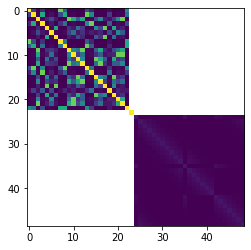

In [55]:
# build the prior; we are only doing this step to be able to look at this cool covariance matrix
# you could also record this to an external file if you really wanted to, but it is pretty huge due to the number of parameters
cov = pf.build_prior(fmt='none')

# and take a peak at a slice of the matrix
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [56]:
pe = pf.draw(num_reals=100, use_specsim=True) # draw parameters from the prior distribution
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-03-16 17:24:13.934185 starting: drawing realizations
2022-03-16 17:24:14.035941 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72


2022-03-16 17:24:14.185006 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.219912 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034906
2022-03-16 17:24:14.222907 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.258807 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035900
2022-03-16 17:24:14.260801 starting: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.05428434

2022-03-16 17:24:14.375494 starting: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.411397 finished: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035903
2022-03-16 17:24:14.414391 starting: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.449296 finished: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034905
2022-03-16 17:24:14.452288 starting: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.0

2022-03-16 17:24:14.566964 starting: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.602872 finished: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035908
2022-03-16 17:24:14.604882 starting: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.640783 finished: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035901
2022-03-16 17:24:14.643411 starting: SpecSim: drawing 100 realization for group rch_recharge_12_gr with 706 pars, (log) vari

2022-03-16 17:24:14.759040 starting: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.793953 finished: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034913
2022-03-16 17:24:14.796937 starting: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.832860 finished: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035923
2022-03-16 17:24:14.835848 starting: SpecSim: drawing 100 realization for group rch_recharge_17_gr with 706 pars, (log) vari

2022-03-16 17:24:14.949576 starting: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:14.983522 finished: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.033946
2022-03-16 17:24:14.986512 starting: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:15.021417 finished: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034905
2022-03-16 17:24:15.024378 starting: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) varian

2022-03-16 17:24:15.140102 starting: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:15.176002 finished: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035900
2022-03-16 17:24:15.178000 starting: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:15.212907 finished: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034907
2022-03-16 17:24:15.215898 starting: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) varia

2022-03-16 17:24:15.328441 starting: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:15.363356 finished: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034915
2022-03-16 17:24:15.366311 starting: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:15.400220 finished: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.033909
2022-03-16 17:24:15.403249 starting: SpecSim: drawing 100 realization for group rch_recharge_8_gr with 706 pars, (log) variance 

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-16 17:24:15.659341 finished: spectral simulation for grid-scale pars took: 0:00:01.623400
2022-03-16 17:24:15.659341 starting: Drawing non-specsim pars
building diagonal cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf_k_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k33_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['sto_ss_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_sy_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_10_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_11_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_12_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_13_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_14_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_15_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_16_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_17_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_18_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_19_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_20_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_21_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_22_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_23_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_24_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_25_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_4_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_5_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_6_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_7_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_8_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_9_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcond_gr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['wel_cst']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
working on pargroups ['sfr_gr']


build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


adding remaining parameters to diagonal


2022-03-16 17:24:21.239327 finished: Drawing non-specsim pars took: 0:00:05.579986


2022-03-16 17:24:22.945215 finished: drawing realizations took: 0:00:09.011030


noptmax:0, npar_adj:25454, nnz_obs:920
